# This notebook provides the code used in the EconGraphs module.

In [10]:
from __future__ import division

%pylab inline


from scipy.integrate import quad
from copy import copy, deepcopy
from scipy import optimize as opt
import numpy as np
from array import array
import matplotlib.pyplot as plt
from ipywidgets import interact, interactive, fixed
import ipywidgets as widgets


#class holding normal, inverse, and vectorized demand functions
class demandFunc():
    
    def __init__(self,**params):
        for key in params:
                setattr(self, key, params[key])

    def demand(self, P):
        
        return self.multiplier*(P**-self.elasticity)
        
    def invDemand(self, Q):
        
        return (self.multiplier/Q)**(1/self.elasticity)
    
    def demandCurve(self, Pvec):
        '''
        Pvec is a vector of prices
        '''
        return map(self.demand, Pvec)
    
    def invDemandCurve(self, Qvec):
        '''
        Qcev is a vector of quantities
        '''
        return map(self.invDemand, Qvec)
        
    def invDemandCurveSubs(self, Qvec, subsidy):
        '''
        Qcev is a vector of quantities
        '''
        return map(lambda Qvec : self.invDemand(Qvec) + subsidy, Qvec)

        
#class holding normal, inverse, and vectorized supply functions        
class supplyFunc():

    def __init__(self,interval_points):
        '''
        interval points is a set of tupples (Q,P)
        '''
        self.interval_points = copy(interval_points)
        self.interval_points.sort(reverse=True)
        
    def supply(self,P):

        highest_q = self.interval_points[0][0]
        for q,p in self.interval_points:
            if p > P:
                highest_q = q
                continue
            if p <= P:
                return highest_q
        return highest_q
            
    def invSupply(self, Q):
               
        highest_p = self.interval_points[0][1]
        for q,p in self.interval_points:
            if q < Q:
                return p
            if q >= Q:
                highest_p = p
                continue
        return highest_p

    def supplyCurve(self, Pvec):
        '''
        Pvec is a vector of prices
        '''
        return map(self.supply, Pvec)
    
    def invSupplyCurve(self, Qvec):
        '''
        Qvec is a vector of quantities
        '''
        return map(self.invSupply, Qvec)

#objet for interacting/analyzing supply and demand functions
class market(object):
    
    def __init__(self, demandFunc, supplyFunc):
        self.demandFunc, self.supplyFunc = demandFunc, supplyFunc
        '''
        if ad < az:
            raise ValueError('Insufficient demand.')
        '''
        self.findEQ()
        self.find_cSurplus()
    
    def findEQ(self):
        "Return equilibrium price"

        #correct any points in the supply func where price is negative
        self.supplyFunc.interval_points = [(i,0) if j < 0 else (i,j) for i,j in self.supplyFunc.interval_points] 

        
        self.ranges = ((1,(self.supplyFunc.interval_points[0][1])*1.2))
        optimalFunc = lambda q : np.abs(self.demandFunc.invDemand(q) - self.supplyFunc.invSupply(q))
        results = opt.brute(optimalFunc, (self.ranges, ), full_output=True,
                              finish=opt.fmin)
        self.equilibriumQ = results[0][0]
        self.equilibriumP = self.demandFunc.invDemand(self.equilibriumQ)
    
    def find_cSurplus(self):
        "Compute consumer surplus"
        intDemand, errorD = quad(self.demandFunc.invDemand, 1, self.equilibriumQ)
        intSupply, errorS = quad(self.supplyFunc.invSupply, 1, self.equilibriumQ)
        intDemand += self.demandFunc.invDemand(1) #TODO: make sure this is correct
        self.consumerSurplus = intDemand - intSupply
        

/home/alex/anaconda2/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


Populating the interactive namespace from numpy and matplotlib


In [176]:
#this object simulates and graphs various market scenarios
class scenarioSimulator(object):
    
    def __init__(self, market):
        self.market              = market
        self.grid                = np.linspace(1,(self.market.supplyFunc.interval_points[0][1]*1.2), 300)
        self.subsidy             = False
        self.plotPoints = [{'equilibrium' : (market.equilibriumQ, market.equilibriumP)},{}]
        self.surplusParams       = {
                                    'facecolor':'green',
                                    'alpha'    :.3,
                                    'label'    :'surplus'
                                    }
        self.surplusAddParams = {
                                    'color'  :  'blue',
                                    'alpha'  :  .3,
                                    'label'  :  'new surplus'
                                    }
        self.surplusLossParams = {
                                    'color'  :  'red',
                                    'alpha'  :  .2,
                                    'label'  :  'lost surplus'
                                    }        
        self.titlefont           = {
                                    'family' : 'serif',
                                    'color'  : 'black',
                                    'weight' : 'bold',
                                    'size'   : 16,
                                    }
        self.labelfont           = {
                                    'family' : 'sans-serif',  # (cursive, fantasy, monospace, serif)
                                    'color'  : 'black',       # html hex or colour name
                                    'weight' : 'normal',      # (normal, bold, bolder, lighter)
                                    'size'   : 14,            # default value:12
                                    }
        self.linesize            = {
                                    'lw'     : 2,
                                    'alpha'  : 0.6
                                   }
        self.dottedline          = {
                                    'lw'     :  1,
                                    'alpha'  :  1,
                                    'ls'     :  'dashed',
                                    'color'  :  'black'
                                    }
    #describes the social welfare objective function for a capital expenditure variable
    @staticmethod
    def capExpObjectiveFunc(split_points,*params):
        
        q_pct, budget_split = split_points
        market, otherMarket, totalSupply, budget = params
        
        shift = (budget * budget_split, budget * (1-budget_split))

        supplyShiftMarket = deepcopy(market)
        otherSupplyShiftMarket = deepcopy(otherMarket)
            
        for plotNum, market in enumerate([supplyShiftMarket,otherSupplyShiftMarket]):
            market.supplyFunc.interval_points = [(i,j+shift[plotNum]) for i,j in market.supplyFunc.interval_points] 
            market.findEQ()
            
        
        surplusEquation1 = lambda q: supplyShiftMarket.demandFunc.invDemand(q) - supplyShiftMarket.supplyFunc.invSupply(q)
        surplusEquation2 = lambda q: otherSupplyShiftMarket.demandFunc.invDemand(q) - otherSupplyShiftMarket.supplyFunc.invSupply(q)
        
        intDemand1 = lambda q: quad(surplusEquation1, 1, q)[0] # + supplyShiftMarket.demandFunc.invDemand(q)
        intDemand2 = lambda q: quad(surplusEquation2, 1, q)[0] # + otherSupplyShiftMarket.demandFunc.invDemand(q)

        invConsumerSurplus =  -1*(intDemand1(q_pct*totalSupply) + intDemand2((1-q_pct)*totalSupply))
        return invConsumerSurplus
         
    def plotDemand(self,ax):
        return ax.plot(self.grid, self.market.demandFunc.invDemandCurve(self.grid), label = 'demand', **self.linesize)
        
    def plotSupply(self,ax):
        return ax.plot(self.grid, self.market.supplyFunc.invSupplyCurve(self.grid), label = 'supply', **self.linesize)
    
    def plotHouseholds(self,ax, interval = .25, priceLevel = None):
        
        qLevel = int(self.market.demandFunc.demand(priceLevel)*(1/interval)) / (1/interval) #round quantity to closest <interval>
        yLine  = lambda q : 0
        intervalPoints = np.arange(0,qLevel, interval)
        points = [qLevel] * 50
        self.plotPoints[0]['quantity consumed'] = (points, np.linspace(0, self.market.demandFunc.invDemand(qLevel),50).tolist())

        for i in intervalPoints:
            pointList = [np.array([i,i+interval]), np.linspace(i,i+interval,200,endpoint=True)]
            prices    = self.market.demandFunc.invDemandCurve(np.array([i+interval]))
            pLine     = lambda p : prices[0]
            if i == intervalPoints[-1]:
                ax.fill_between(
                                pointList[1],
                                pLine(pointList[1]),
                                yLine(pointList[1]),
                                color = 'blue', alpha = .15,
                                label = 'Benefit'
                                )
                ax.fill_between(
                                pointList[0],
                                pLine(pointList[0]),
                                yLine(pointList[0]),
                                where = self.market.demandFunc.invDemandCurve(pointList[0]) <= prices[0],
                                color = 'blue', alpha = .4
                                )
            else:
                ax.fill_between(
                                pointList[1],
                                pLine(pointList[1]),
                                yLine(pointList[1]),
                                color = 'blue', alpha = .15
                                )
                ax.fill_between(
                                pointList[0],
                                pLine(pointList[0]),
                                yLine(pointList[0]),
                                where = self.market.demandFunc.invDemandCurve(pointList[0]) <= prices[0],
                                color = 'blue', alpha = .4
                                )
    
    def plotDemandShift(self,ax,demandShift = None,populationShift = None, plotNum = 1):
        self.demandShiftMarket = deepcopy(self.market)
        if not self.subsidy: 
            self.demandShiftMarket.demandFunc.multiplier += demandShift
        self.demandShiftMarket.findEQ()
        self.plotPoints[plotNum - 1]['new equilibrium'] = ((self.demandShiftMarket.equilibriumQ, self.demandShiftMarket.equilibriumP))
        if not self.subsidy:
            self.demandShiftPlot   = self.demandShiftMarket.demandFunc.invDemandCurve(self.grid)
        else:
            self.demandShiftPlot   = self.demandShiftMarket.demandFunc.invDemandCurveSubs(self.grid, demandShift)
        ax.plot(self.grid, self.demandShiftPlot, label = 'new demand', **self.linesize)
    
    def plotSupplyShift(self,ax,supplyShift = None, intervals = None, newPoint = None, replacePoint = None, plotNum = 1):
        self.supplyShiftMarket = deepcopy(self.market)
        if intervals:
            newPoints = []
            intervalCounter = 0
            for x,y in enumerate(self.market.supplyFunc.interval_points):
                if x in intervals:
                    newPoints.append((y[0],y[1]+supplyShift[intervalCounter]))
                    intervalCounter += 1
                else:
                    newPoints.append(y)
            self.supplyShiftMarket.supplyFunc.interval_points = newPoints
        elif newPoint:
            newPoints = copy(self.market.supplyFunc.interval_points)
            currentLevel = newPoints[0][0]
            for points in newPoints:
                if newPoint[0] > points[1]:
                    break
                currentLevel = points[0]-.01
            newPoints.append((currentLevel,newPoint[0]))
            newPoints.sort(reverse=True)
            newPoints = [(i+newPoint[1],j) if i > currentLevel else (i,j) for i,j in newPoints]
            self.supplyShiftMarket.supplyFunc.interval_points = newPoints 
        else:
            self.supplyShiftMarket.supplyFunc.interval_points = [(i,j+supplyShift) for i,j in self.market.supplyFunc.interval_points] 
        self.supplyShiftMarket.findEQ()
        self.plotPoints[plotNum - 1]['new equilibrium'] = ((self.supplyShiftMarket.equilibriumQ, self.supplyShiftMarket.equilibriumP))
        self.supplyShiftPlot   = self.supplyShiftMarket.supplyFunc.invSupplyCurve(self.grid)
        ax.plot(self.grid, self.supplyShiftPlot, label = 'new supply', **self.linesize)
    
    def plotSurplus(self,ax,price = None):
        try:
            ax.fill_between(
                            self.grid,
                            self.market.demandFunc.invDemandCurve(self.grid), 
                            self.market.supplyFunc.invSupplyCurve(self.grid), 
                            where = self.market.demandFunc.invDemandCurve(self.grid) > np.maximum(price,self.market.equilibriumP), 
                            **self.surplusParams
                            )
        except AttributeError:
            pass
        
    def plotSupplyChangeSurplus(self,ax,supplyShift = None):
        try:
            if supplyShift >= 0:
                ax.fill_between(
                                self.grid,
                                self.market.supplyFunc.invSupplyCurve(self.grid), 
                                np.minimum(self.supplyShiftMarket.supplyFunc.invSupplyCurve(self.grid),self.market.demandFunc.invDemandCurve(self.grid)),
                                where = self.market.demandFunc.invDemandCurve(self.grid) > self.market.equilibriumP, 
                                **self.surplusLossParams
                                )      
            else:  
                ax.fill_between(
                                self.grid,
                                self.supplyShiftMarket.supplyFunc.invSupplyCurve(self.grid), 
                                np.minimum(self.market.supplyFunc.invSupplyCurve(self.grid), self.market.demandFunc.invDemandCurve(self.grid)), 
                                where = self.market.demandFunc.invDemandCurve(self.grid) > self.supplyShiftMarket.equilibriumP, 
                                **self.surplusAddParams
                                )        
        except AttributeError:
            pass
        
    def plotDemandChangeSurplus(self,ax,demandShift = None):
        try:
            if demandShift >= 0:
                ax.fill_between(
                                self.grid,
                                self.demandShiftMarket.demandFunc.invDemandCurve(self.grid), 
                                np.maximum(self.market.demandFunc.invDemandCurve(self.grid), self.market.supplyFunc.invSupplyCurve(self.grid)),
                                where = self.demandShiftMarket.demandFunc.invDemandCurve(self.grid) > self.demandShiftMarket.equilibriumP,
                                **self.surplusAddParams
                                )        
            else:
                ax.fill_between(
                                self.grid,
                                self.market.demandFunc.invDemandCurve(self.grid), 
                                np.maximum(self.demandShiftMarket.demandFunc.invDemandCurve(self.grid), self.market.supplyFunc.invSupplyCurve(self.grid)), 
                                where = self.market.demandFunc.invDemandCurve(self.grid) > self.market.equilibriumP, 
                                **self.surplusLossParams
                                )        
        except AttributeError:
            pass

        
    def annotate(self):
        
        #should add marginal surplus and calculate total surplus for comparisons
        for i, ax in enumerate(self.fig.axes):
            plotPoints = self.plotPoints[i]
            for key,value in plotPoints.iteritems():
                if key == 'equilibrium' or key == 'new equilibrium':
                    ax.plot(value[0], value[1], 'or')
                    #make changes to the second tupple to move the text location
                    ax.annotate(str(key), (value[0],value[1]), (value[0]+value[0]/10,value[1]+value[0]/10) )
                    continue
                ax.plot(value[0], value[1], **self.dottedline)
                ax.text(value[0][-1], value[1][-1], str(key), **self.labelfont)
        self.plotPoints = [{'equilibrium' : (self.market.equilibriumQ, self.market.equilibriumP)}, {}]
                
    def drawShadowValue(self,quantity, scarcityRent = False, annotate=False):
        
        priceLevel = self.market.demandFunc.invDemand(quantity)
        
        if scarcityRent:
            self.drawFigure(drawSurplus = True, priceLevel = priceLevel, EQ = False)
        else:
            self.drawFigure(drawSurplus = False, priceLevel = priceLevel, EQ = False)

        points = [quantity] * 50
        
        if annotate:
            if scarcityRent:
                self.plotPoints[0]['scarcity rent'] = (points, np.linspace(self.market.supplyFunc.invSupply(quantity),priceLevel,50).tolist())            
            else:
                self.plotPoints[0]['shadow price']  = (points, np.linspace(0, priceLevel,50).tolist())
            self.annotate()
        
    def drawQuantity(self,quantity,annotate=False):
        
        self.drawFigure(priceLevel = self.market.demandFunc.invDemand(quantity),EQ=False)
        points = [quantity] * 50
        self.plotPoints[0]['quantity'] = (points, np.linspace(0, self.market.demandFunc.invDemand(quantity),50).tolist())
        if annotate:
            self.annotate()
        
    def drawDemand(self, demandShift = None, annotate = False, subsidy = None):
        
        if subsidy:
            self.subsidy = True
            demandShift = subsidy
        
        title = "Aggregate Demand for Water"
        self.drawFigure(noSupply=True, EQ=False, drawSurplus = False, demandShift = demandShift)
        try:
            del self.plotPoints[0]['equilibrium']
        except KeyError:
            pass
        if demandShift:
            del self.plotPoints[0]['new equilibrium']
        if annotate:
            self.annotate()
        
    def drawHouseholds(self,price, annotate = False, **kwargs):
        
        self.drawFigure(priceLevel = price, households = True, showSurplus = False,**kwargs)
        try:
            del self.plotPoints[0]['equilibrium']
        except KeyError:
            pass
        if annotate:
            self.annotate()
        
    def drawSupplyShift(self, shift = 1, intervals = None, newPoint = None, replacePoint = None):
        
        if intervals:
            self.drawFigure(supplyShift=shift,intervals = intervals)
        elif newPoint:
            self.drawFigure(supplyShift=shift,newPoint = newPoint, replacePoint = replacePoint)
        else:
            self.drawFigure(supplyShift=shift,intervals = None)
        
    
    def drawDemandShift(self,shift=1):
        
        self.drawFigure(demandShift=shift)
        
    def drawShifts(self, demandShift=1, supplyShift=1):

        self.drawFigure(demandShift=demandShift, supplyShift=supplyShift)

    def drawCapitalExpTradeoff(self,budget, budget_split, totalSupply = None, q_split = None, otherMarket = None, optimize = False, drawEQ = False):
        
        budget = -budget
        
        if drawEQ:
            
            supplyShift1 = budget*budget_split
            supplyShift2 = budget*(1-budget_split)
            
            self.drawFigure(supplyShift1=supplyShift1,supplyShift2=supplyShift2,numPlots=2,otherMarket=otherMarket,
                      priceLevel=None,price2=None)
            
            self.fig.suptitle('Capital Expenditure Tradeoff')
            
            return
        
        market = self.market
        q_pct = q_split
        
        if optimize:
        
            params = (market, otherMarket, totalSupply, budget)
            result = opt.brute(self.capExpObjectiveFunc,((.001,.999),(.001,.999)), args=params, full_output=True,finish=None)

            q_pct, budget_split = result[0]

        self.market.supplyFunc.interval_points = [(i,j+budget_split * budget) for i,j in market.supplyFunc.interval_points] 
        self.market.findEQ()
        self.plotPoints[0]['equilibrium'] = (market.equilibriumQ, market.equilibriumP)
        
        otherMarket.supplyFunc.interval_points = [(i,j+(1-budget_split) * budget) for i,j in otherMarket.supplyFunc.interval_points] 
        otherMarket.findEQ()
        
        self.drawTradeoff(totalSupply,q_pct,otherMarket = otherMarket)

        if optimize:
                                    
            self.fig.suptitle('Optimal Capital Expenditure Tradeoff')

        else:
            
            self.fig.suptitle('Capital Expenditure Tradeoff')
        
    def drawPopulationShift(self,size,away=False):
        
        if away:
            size=-size
        demandShift1 = size
        demandShift2 = -size
        
        self.drawFigure(demandShift1=demandShift1,demandShift2=demandShift2,numPlots=2,otherMarket=None,
                      priceLevel=None,price2=None)
        
    def drawOptimalTradeoff(self,totalSupply,otherMarket = None, annotate = False):
        #need to add back integrals for Q < 1 for precise calculation - but this is still OK for graphing!
        if self.market.equilibriumQ + otherMarket.equilibriumQ <= totalSupply:
            raise ValueError('totalSupply is too large, there is no constraint!')
        surplusEquation1 = lambda q: self.market.demandFunc.invDemand(q) - self.market.supplyFunc.invSupply(q)
        surplusEquation2 = lambda q: otherMarket.demandFunc.invDemand(q) - otherMarket.supplyFunc.invSupply(q)
        
        intDemand1 = lambda q: quad(surplusEquation1, 1, q)[0] # + self.market.demandFunc.invDemand(q)
        intDemand2 = lambda q: quad(surplusEquation2, 1, q)[0] # + otherMarket.demandFunc.invDemand(q)
        
        if self.fig._suptitle is None:
            self.fig.suptitle('Optimal Regional Water Tradeoff', fontsize=14)

        
        objectiveFunction = lambda q_pct : -1*(intDemand1(q_pct*totalSupply) + intDemand2((1-q_pct)*totalSupply))
        result = opt.brute(objectiveFunction,((.001,.999), ),full_output=True,finish=opt.fmin)
        self.drawTradeoff(totalSupply,result[0][0],otherMarket = otherMarket)
                
        if annotate:
            self.annotate()
        
    def drawTradeoff(self,totalSupply,firstMarketFrac,otherMarket = None,annotate=False):
                
        if firstMarketFrac < 0 or firstMarketFrac > 1:
            raise ValueError('Input must be numeric between 0 and 1 inclusive.')
        quant1 = totalSupply * firstMarketFrac
        quant2 = totalSupply - quant1
        price1 = self.market.demandFunc.invDemand(quant1)
        q_level1 = self.market.supplyFunc.invSupply(quant1)
        if otherMarket is not None:
            price2 = otherMarket.demandFunc.invDemand(quant2)
            q_level2 = otherMarket.supplyFunc.invSupply(quant2)
        else:
            price2 = self.market.demandFunc.invDemand(quant2)
            q_level2 = self.market.supplyFunc.invSupply(quant2)

        self.drawFigure(priceLevel=price1,price2=price2,otherMarket=otherMarket,numPlots=2,EQ=False)
        
        marginal_surplus1 = round(price1 - q_level1,3)
        marginal_surplus2 = round(price2 - q_level2,3)
        self.plotPoints[0]['Marginal Surplus: ' + str(marginal_surplus1)] = ([quant1] * 50,np.linspace(q_level1,price1, 50).tolist())
        self.plotPoints[1]['Marginal Surplus: ' + str(marginal_surplus2)] = ([quant2] * 50,np.linspace(q_level2,price2, 50).tolist())
        
        if self.fig._suptitle is None:
            self.fig.suptitle('Regional Water Tradeoff', fontsize=14)
            
        if annotate:
            self.annotate()
        
    def drawFigure(self, numPlots=1, EQ = True, **kwargs):
        fig, ax_array = plt.subplots(1, numPlots,figsize = (5*numPlots,5),sharey=True)
        for i,ax in enumerate(np.ravel(ax_array)):
            
            ax.set_xlim([1,self.market.supplyFunc.interval_points[0][1]])
            ax.set_ylim([1,self.market.supplyFunc.interval_points[0][0]*2.5])
            try:
                kwargs['demandShift'] = kwargs['demandShift'+str(i+1)]
            except KeyError:
                pass
            try:
                kwargs['supplyShift'] = kwargs['supplyShift'+str(i+1)]
            except KeyError:
                pass
            if i == 0:
                self.drawAxes(ax, EQ=EQ, plotNum = i+1,**kwargs)
                continue
            if kwargs['otherMarket'] is not None:
                self.tempMarket = deepcopy(self.market)
                self.market = deepcopy(kwargs['otherMarket'])
            del kwargs['priceLevel']
            self.plotPoints[i]['equilibrium'] = (self.market.equilibriumQ, self.market.equilibriumP)
            self.drawAxes(ax, EQ=EQ, priceLevel=kwargs['price2'], plotNum = i+1, **kwargs)
            if kwargs['otherMarket'] is not None:
                self.market = deepcopy(self.tempMarket)
        self.fig=fig
        if 'annotate' in [key for key, value in kwargs.iteritems()]:
            if kwargs['annotate'] is True:
                self.annotate()
        
        
    def drawAxes(self,ax,showSurplus=True, supplyShift = None, demandShift = None, households = None, noSupply = False, **kwargs):
        
        #unpack key word arguments
        for i in kwargs:
            try:
                exec('%s = %s' % (i, repr(kwargs[i])))
            except SyntaxError:
                continue
        
        if 'drawSurplus' in locals():
            showSurplus = drawSurplus
        
        for var in ['intervals','newPoint','replacePoint']:
            if var in locals():
                pass
            else:
                exec('%s = None' % (var))
                
        #set up titles / markings for graph
        title = 'Supply and Demand for Water'
        xlab = 'Quantity of Water (Mcm/capita)'
        
        self.plotDemand(ax)
        if households:
            self.plotHouseholds(ax,priceLevel=priceLevel)
            title = "Individual Household's Demand for Water"
            xlab = 'Quantity of Water (cm)'
        else: 
            if not noSupply:
                self.plotSupply(ax)
        if supplyShift:
            self.plotSupplyShift(ax, plotNum = plotNum, supplyShift=supplyShift, intervals = intervals, newPoint = newPoint, replacePoint = replacePoint)
        if demandShift:
            self.plotDemandShift(ax, plotNum = plotNum, demandShift=demandShift)
        if showSurplus:
            if not EQ:
                self.plotSurplus(ax,price=np.array(priceLevel))
                title = 'Water Constraints in Region ' + str(plotNum)
                self.titlefont['size']=12
            else:
                self.plotDemandChangeSurplus(ax, demandShift=demandShift)
                if newPoint:
                    supplyShift = -1
                self.plotSupplyChangeSurplus(ax, supplyShift=supplyShift)
                title = 'InterRegional Water Allocation'
                self.plotSurplus(ax, price = self.market.equilibriumP)
        
        ax.set_title(title, fontdict=self.titlefont) 
        ax.set_xlabel(xlab, fontdict=self.labelfont)
        ax.set_ylabel('Price ($/mcm)', fontdict=self.labelfont)
        ax.legend(loc='best', frameon=False, fontsize=12, markerscale=.6,ncol=2,columnspacing=.8)
        
        self.supplyShiftMarket, self.demandShiftMarket= None, None
        


In [171]:
#example params
supplyLevels           = [(1,2),(3,4),(6,7)]
highlandsSupplyLevels  = [(i,j+3) for i,j in supplyLevels]
springAreaSupplyLevels = [(i,j-1) for i,j in supplyLevels]
demand_parameters = {'multiplier':7,'elasticity':.7}
alt_demand_parameters = {'multiplier':6,'elasticity':.7}

#example objects
Market = market(demandFunc(**demand_parameters), supplyFunc(supplyLevels))
highAltMarket = market(demandFunc(**demand_parameters), supplyFunc(highlandsSupplyLevels))
springMarket = market(demandFunc(**demand_parameters), supplyFunc(springAreaSupplyLevels))
graphMaker = scenarioSimulator(Market)


Current LEvel
6
[(6, 7), (3, 4), (1, 2)]
[(6, 7), (3, 4), (1, 2), (2.99, 3)]
[(7, 7), (4, 4), (2.99, 3), (1, 2)]


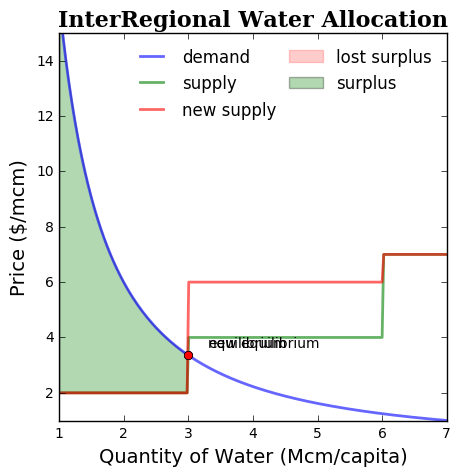

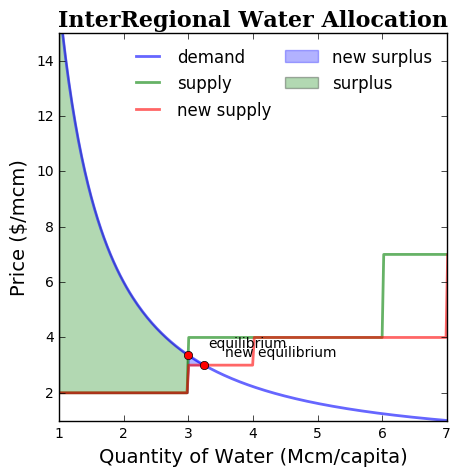

In [172]:
if __name__ == '__main__':

    #test graphs
    '''
    graphMaker.drawFigure(annotate=True)
    
    graphMaker.drawDemand()
    
    graphMaker.drawDemand(subsidy = 3, annotate = True)
    
    graphMaker.drawShadowValue(2, scarcityRent=False, annotate=True)

    graphMaker.drawQuantity(2.5)
    graphMaker.annotate()

    graphMaker.drawDemandShift(4)
    graphMaker.annotate()
    
    graphMaker.drawDemandShift(-2)
    graphMaker.annotate()
    
    graphMaker.drawSupplyShift()
    graphMaker.annotate()
    
    graphMaker.drawSupplyShift(-1)
    graphMaker.annotate()
    '''
    graphMaker.drawSupplyShift([2],[1])
    graphMaker.annotate()

    graphMaker.drawSupplyShift(newPoint = (3,1))
    graphMaker.annotate()

    '''
    graphMaker.drawHouseholds(4)
    graphMaker.annotate()

    graphMaker.drawPopulationShift(2,away=True)
    graphMaker.annotate()

    graphMaker.drawCapitalExpTradeoff(3,.4,drawEQ=True)
    graphMaker.annotate()

    graphMaker.drawCapitalExpTradeoff(1,.2,totalSupply = 4, q_split = .6, otherMarket=springMarket)
    graphMaker.annotate()
    
    graphMaker.drawOptimalTradeoff(4, otherMarket=Market)
    graphMaker.annotate()
    
    graphMaker.drawCapitalExpTradeoff(1, .4, totalSupply = 4, otherMarket = springMarket, optimize=True)
    graphMaker.annotate()

    graphMaker.drawFigure(drawSurplus = False)
    graphMaker.annotate()
    
    graphMaker.drawTradeoff(4,.4)
    graphMaker.annotate()
    
    graphMaker.drawShifts()
    graphMaker.annotate()

    graphMaker.drawOptimalTradeoff(4, otherMarket = springMarket)
    graphMaker.annotate()
    '''
    


In [26]:
    # functions for interactive graphs

    def buildSupplyPoints(width, height, steps):
        supplyPoints = [(0,height)] 
        supplyPoints.extend([(supplyPoints[0][0]+width*(i+1),supplyPoints[0][1]+height*(i+1)) for i in range(int(steps/width))])
        return supplyPoints

    def makeTupples(kwargDict):
        mixMaxRangeTupples = {}
        for k,v in kwargDict.iteritems():
            try:
                mixMaxRangeTupples[k]=(v-2*v,v+2*v,v/50)
            except TypeError:
                continue
        return mixMaxRangeTupples
    
    def avoidNull(simulatorObjFunc,*args):
        return simulatorObjFunc(*args)
    

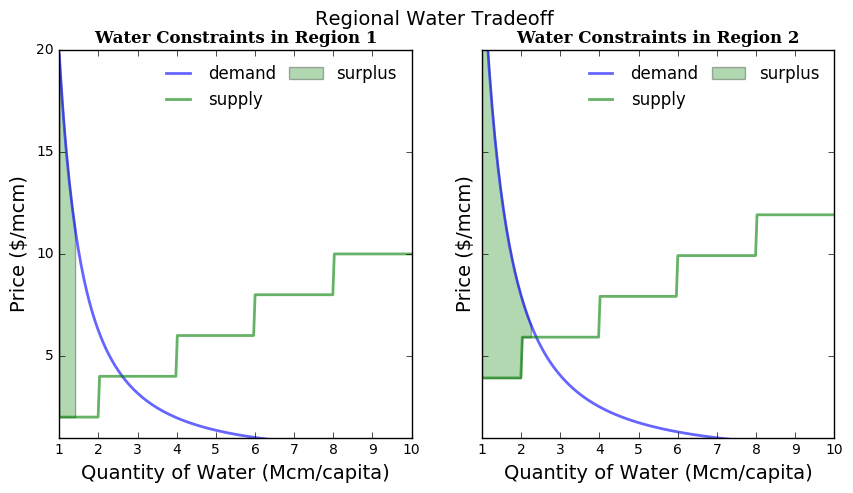

In [28]:
    kwargDict = {
             'optimize':'True', 
             'waterSupply':4,
             'waterSharePct':.4,
             'supplyChange':2,
             'demandChange':1
            }


    kwargDict1 = {
                 'optimize':'True',
                 'waterSupply':40, 
                 'waterSharePct':.4, 
                 'demandMult1':60,
                 'demandMult2':60,
                 'demandElas1':.6,
                 'demandElas2':.6,
                 'stepWidth1':2,
                 'stepHeight':2,
                 'steps':8,
                 'supplyChange':2,
                 'demandChangeM':1,
                 'demandChangeE':.1,
                }
    
    @interact(**makeTupples(kwargDict))
    def compareMarketsSimple(optimize=('True','False'),waterSharePct=None,waterSupply=None,supplyChange=None,demandChange=None):
        supplyLevels = buildSupplyPoints(2,2,8)
        newSupplyLevels = [(i,j+supplyChange) for i,j in supplyLevels]
        demand_parameters = {'multiplier':6,'elasticity':.6}
        newDemand_parameters = {'multiplier':6+demandChange,'elasticity':.6}
        Market = market(demandFunc(**demand_parameters), supplyFunc(supplyLevels))
        newMarket = market(demandFunc(**newDemand_parameters), supplyFunc(newSupplyLevels))
        graphMaker = scenarioSimulator(Market)
        if optimize == 'True':
            graphMaker.drawOptimalTradeoff(totalSupply = waterSupply, otherMarket=newMarket)
        else:
            graphMaker.drawTradeoff(waterSupply,waterSharePct, otherMarket=newMarket)



In [177]:
'''
!jupyter nbconvert --to script EconGraphs.ipynb
!mv EconGraphs.py /home/alex/Documents/Projects/WAS/Code/econgraphs/__init__.py
!rm -f EconGraphs.py
'''

[NbConvertApp] Converting notebook EconGraphs.ipynb to script
[NbConvertApp] Writing 31948 bytes to EconGraphs.py
